In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from pyckmeans import MultiCKMeans

ModuleNotFoundError: No module named 'pyckmeans'

In [ ]:
# Set random seed so this part is reproducible
# https://www.random.org/ 2023-08-09
np.random.seed(3866)

In [6]:
tpm = pd.read_csv("../../../../data/expression/processed/test/V4/IO-Atlas-NSCLC-TPM-TEST-2023-08-10-V4.tsv", 
                  sep='\t', 
                  index_col=0)

In [3]:
import pandas as pd

tpm = pd.read_csv("../../../../data/expression/processed/train/V4/IO-Atlas-NSCLC-TPM-TRAIN-2023-08-10-V4.tsv", 
                  sep='\t', 
                  index_col=0)

minmax = pd.read_csv("../../../../data/expression/processed/train/V4/IO-Atlas-NSCLC-TPM-MinMaxNorm-TRAIN-2023-08-10-V4.tsv", 
                     sep='\t', 
                     index_col=0)

labels = pd.read_csv("../../../../data/expression/processed/train/V4/IO-Atlas-NSCLC-LABEL-TRAIN-2023-08-10-V4.tsv",
                     sep='\t', 
                     index_col=0, 
                     header=None)

ratios = pd.read_csv("../../../../data/expression/processed/train/V4/IO-Atlas-NSCLC-TPM-MinMaxNorm-TRAIN-2023-08-10-V4.taux",
                     sep='\t',
                     header=None, 
                     comment='#')

In [5]:
ratios["ratio"] = ratios[0] + ":::" + ratios[1]

In [6]:
rvalues = pd.DataFrame(index=ratios["ratio"], columns=minmax.columns, dtype=np.float64)

In [7]:
for i, row in ratios.iterrows():
    rvalues.loc[row.ratio] = minmax.loc[row[0], :] / minmax.loc[row[1], :]

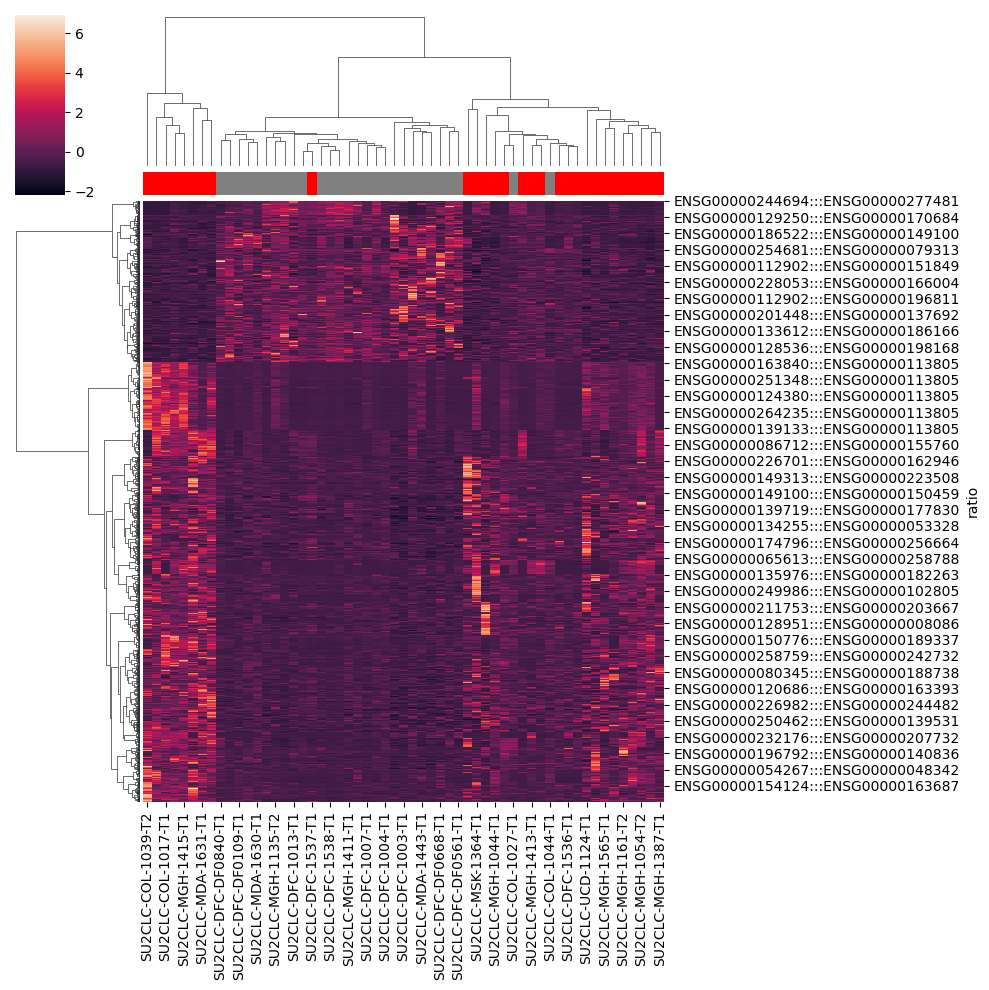

In [8]:
sns.clustermap(rvalues, 
               method="ward", 
               z_score=0, 
               col_colors=["red" if x == 1 else "gray" for x in labels.values])

In [9]:
def search_sample_clusters(exp):
    mckm = MultiCKMeans(k=range(2, 8), n_rep=100, p_samp=0.8, p_feat= 0.8)
    mckm.fit(exp)
    mckm_res = mckm.predict(exp, linkage_type="ward")

    # plot clustering metrics against k
    # BIC, DB: lower is better
    # SIL, CH: higher is better
    mckm_res.plot_metrics(figsize=(10,5))
    
    return mckm_res
    
def assign_sample_clusters(mckm_res, nclusters, prefix=""):
    study_clusters = pd.DataFrame()

    mckm_res_k = mckm_res.ckmeans_results[nclusters - 2]

    # plot consensus matrix and consensus clustering
    fig = mckm_res_k.plot(figsize=(7,7))
    plt.savefig("ratio-clusters.svg", format='svg')

    for sample, cluster in zip(mckm_res.names, mckm_res_k.cl):
        study_clusters.loc[sample, "cluster"] = f"{prefix}{cluster}"
        
    return study_clusters

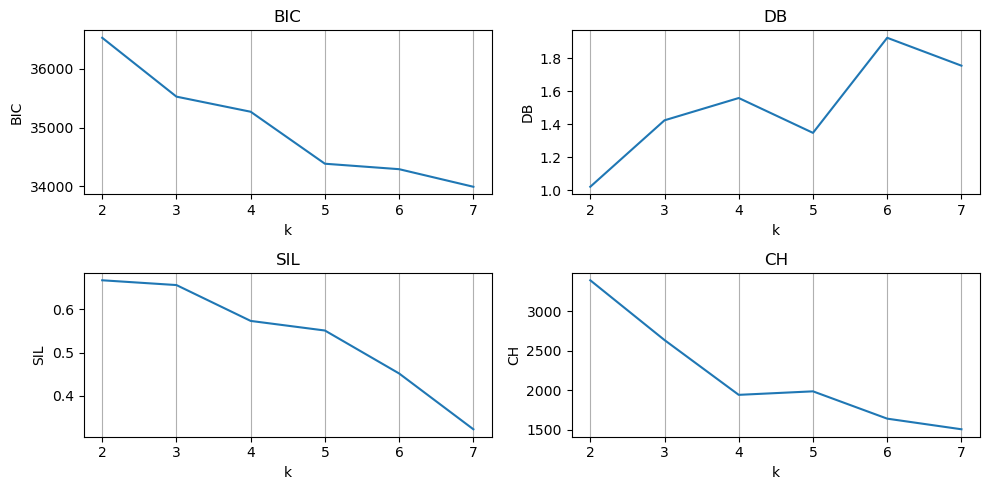

In [10]:
mckm_res = search_sample_clusters(rvalues)

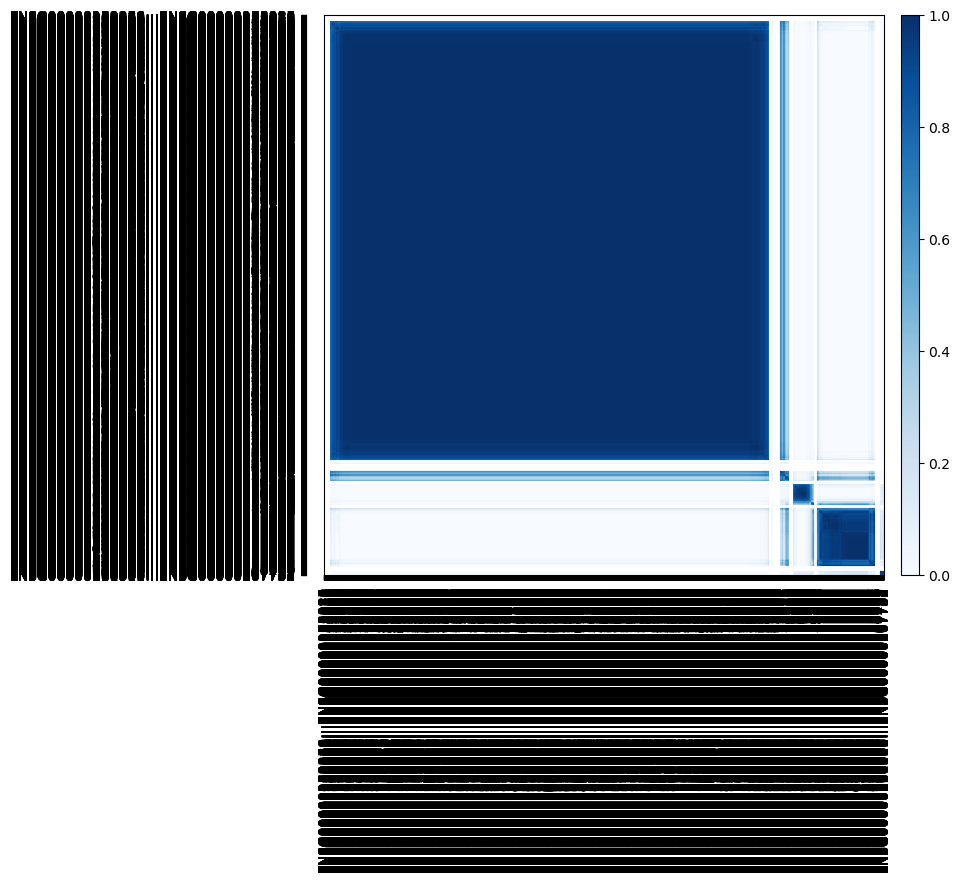

In [11]:
ratio_clusters = assign_sample_clusters(mckm_res, 4, prefix="ratio-cluster")

In [12]:
cluster_gs = []

for cluster, rows in ratio_clusters.groupby("cluster"):

    # Changed to 100 genes from 50 -- Need to finish exploring this
    tmp = ratios.reindex(ratios[ratios["ratio"].isin(rows.index.values)][2].abs().sort_values().tail(100).index.values)

    numerator, denominator = zip(*[x.split(":::") for x in tmp.ratio.values])
    
    for n in numerator:
        cluster_gs.append((cluster, "up", n))
        
    for d in denominator:
        cluster_gs.append((cluster, "down", d))
        
cluster_gs = pd.DataFrame(cluster_gs, columns=["gs", "direction", "gene"])
cluster_gs.to_csv("../../../data/gs/IO-Atlas-NSCLC-TPM-MinMaxNorm-TRAIN-2023-08-10-V4.tsv",
                  sep='\t')

In [13]:
cluster_gs.groupby("gs").count()

,direction,gene
gs,,
ratio-cluster0,200,200
ratio-cluster1,200,200
ratio-cluster2,200,200
ratio-cluster3,200,200
